# Childhood at Risk: Refugees and Malnutrition

Iti Singh Deo DCU Id-10412

# Introduction

As a data analyst aiming to strengthen my skills in data storytelling
and reproducible research, I have chosen to conduct this analysis using
Quarto. Quarto provides a powerful platform that allows me to combine
code, analysis, visualization, and narrative seamlessly within a single,
dynamic document.

For this project, I am working with UNICEF’s development indicator
datasets. These datasets cover a wide range of indicators related to
health, education, and social development across different countries and
years.

## The goals of this analysis are:

To clean and prepare the data for exploration. To perform exploratory
data analysis (EDA) to uncover patterns, trends, and insights. To
generate visualizations that make complex relationships easier to
understand. To practice creating a reproducible and professional report
using Quarto, adhering to best practices in modern data analysis
workflows.

By presenting this analysis in a Quarto document, I aim to produce a
clear, structured, and visually engaging report that could serve both
technical and non-technical audiences, showcasing not just findings but
also analytical thinking and communication skills.

# 2. Combine indicator files

In [2]:
df = pd.concat([indicator_1, indicator_2], ignore_index=True)
df.head()

# 2.1 Data Head and Data Description

In [3]:
df.isnull().sum()

country                                                           0
alpha_2_code                                                     45
alpha_3_code                                                      0
numeric_code                                                      0
indicator                                                         0
time_period                                                       0
obs_value                                                         0
sex                                                               0
unit_multiplier                                                   0
unit_of_measure                                                   0
observation_status                                             2734
observation_confidentaility                                    6391
time_period_activity_related_to_when_the_data_are_collected    2734
current_age                                                       0
dtype: int64

# 3. Data Cleaning: Standardize column names in all DataFrames BEFORE merging

In [4]:
df.columns = [str(x).lower().strip() for x in df.columns]
metadata.columns = [str(x).lower().strip() for x in metadata.columns]
print("Metadata columns:", metadata.columns)

Metadata columns: Index(['country', 'alpha_2_code', 'alpha_3_code', 'numeric_code', 'year',
       'population, total', 'gdp per capita (constant 2015 us$)',
       'gni (current us$)', 'inflation, consumer prices (annual %)',
       'life expectancy at birth, total (years)',
       'military expenditure (% of gdp)',
       'fossil fuel energy consumption (% of total)', 'gdp growth (annual %)',
       'birth rate, crude (per 1,000 people)',
       'hospital beds (per 1,000 people)'],
      dtype='object')

# Rename ‘year’ column in metadata to ‘time_period’

In [5]:
# Rename 'year' column in metadata to 'time_period'
if 'year' in metadata.columns:
    metadata.rename(columns={'year': 'time_period'}, inplace=True)
else:
    print("WARNING: No 'year' column found in metadata.  Merge may fail.")

In [6]:
# Ensure 'time_period' is of the same type in both DataFrames before merging
if 'time_period' in df.columns and 'time_period' in metadata.columns:
    df['time_period'] = pd.to_numeric(df['time_period'], errors='coerce')
    metadata['time_period'] = pd.to_numeric(metadata['time_period'], errors='coerce')
else:
    print("WARNING: One or both DataFrames are missing the 'time_period' column. Merge may fail or be incomplete.")

# 4. Merge with metadata

In [7]:
if 'country' in df.columns and 'time_period' in df.columns and 'country' in metadata.columns and 'time_period' in metadata.columns:
    df = pd.merge(df, metadata,
                  on=['country', 'time_period'],
                  how='left',
                  suffixes=('', '_meta'))
else:
    print("ERROR: 'country' and/or 'time_period' columns are missing from one or more DataFrames.  Cannot proceed with merge.")
    exit()

# 5. Remove columns with \>50% missing values

In [8]:
missing_values = df.isnull().mean()
cols_to_drop = missing_values[missing_values > 0.5].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)
df.head()

5 rows × 25 columns

# 6. Handle remaining missing values

In [9]:
    df['obs_value'] = df['obs_value'].fillna(0)
    df = df.dropna(subset=['country', 'time_period'])

# 7. Enhanced Feature Engineering

In [10]:
if 'population, total' in df.columns:
    df['refugees_per_100k'] = (df['obs_value'] / df['population, total']) * 100000
    df['refugee_burden_ratio'] = df['obs_value'] / df['population, total']

# 8. Use The Cleaned Data:

In [11]:
df=pd.read_csv(r"Data\Cleaned_Data.csv")

# 9. EDA

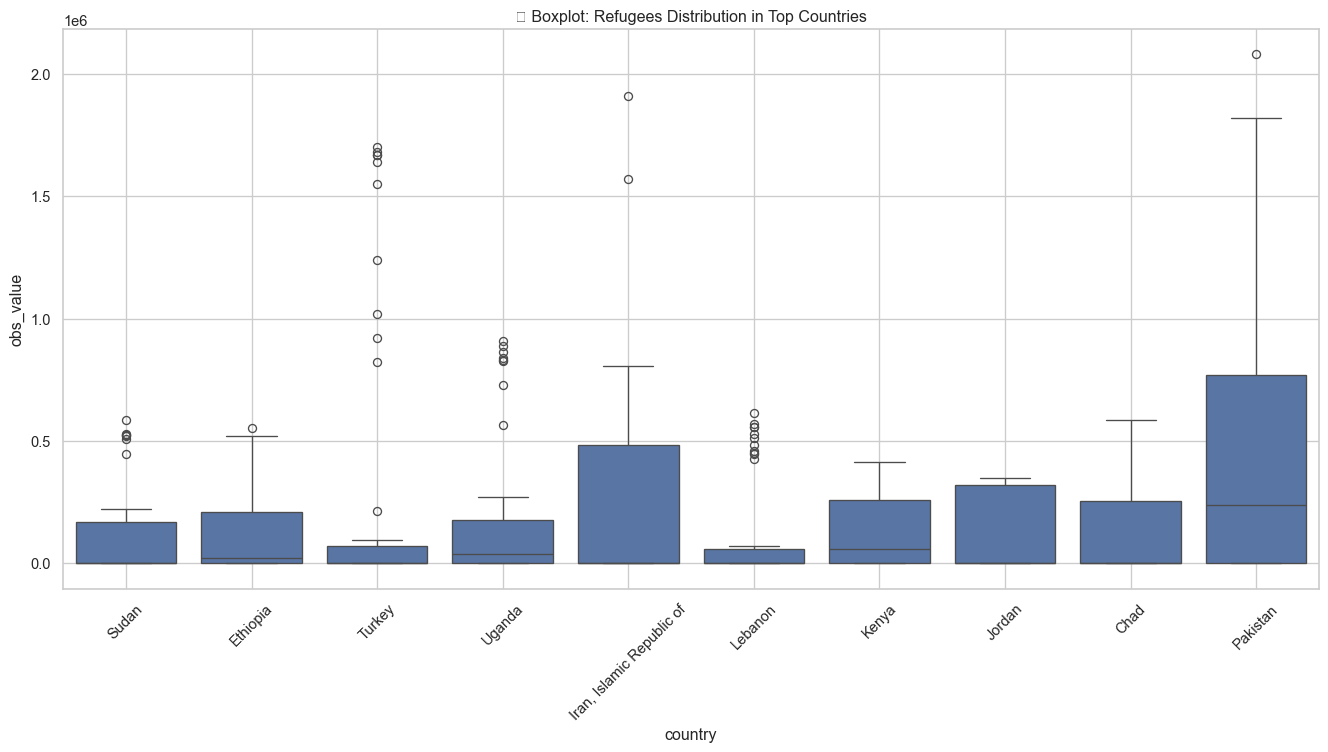

<Figure size 672x480 with 0 Axes>

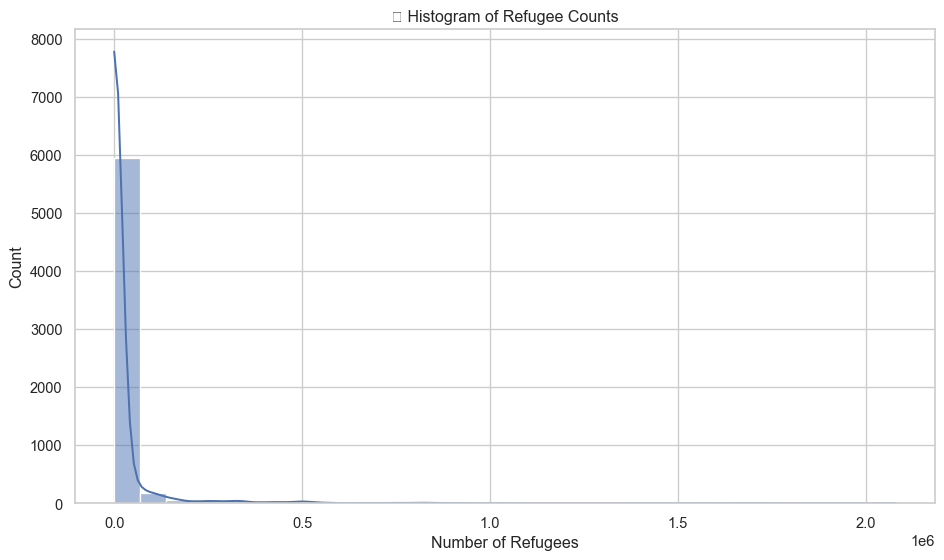

🔎 Number of Outliers Detected: 0

<Figure size 672x480 with 0 Axes>

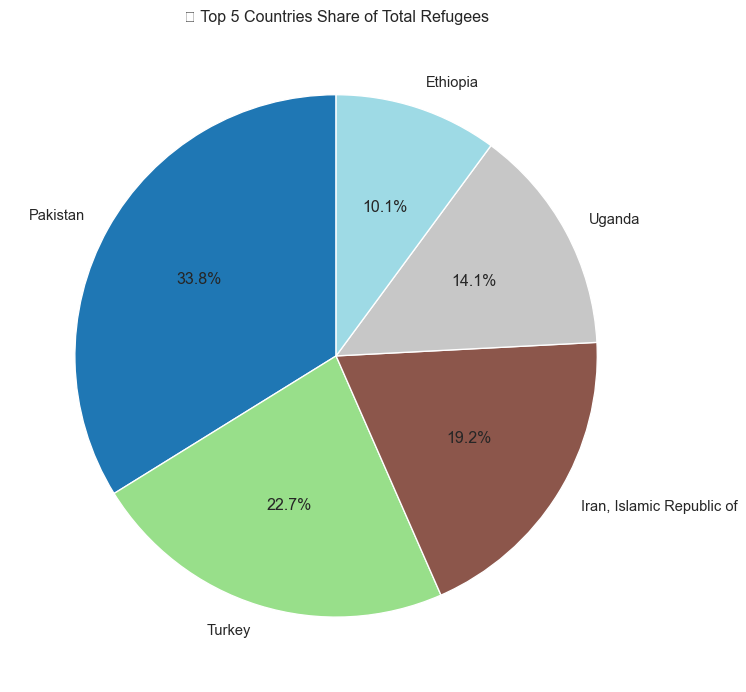

<Figure size 672x480 with 0 Axes>

In [12]:
# Define top_countries based on total refugees (assuming you want top 10)
top_countries = df.groupby('country')['obs_value'].sum().sort_values(ascending=False).head(10)

# --- Insight : Boxplot (Refugees Distribution by Country) ---
plt.figure(figsize=(14,8))
top_countries_list = top_countries.index.tolist()
sns.boxplot(data=df[df['country'].isin(top_countries_list)], x='country', y='obs_value')
plt.title('📦 Boxplot: Refugees Distribution in Top Countries')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(f"{save_dir}/boxplot.png")

# --- Insight : Histogram - Distribution of Refugee Counts ---
plt.figure(figsize=(10,6))
sns.histplot(df['obs_value'], bins=30, kde=True)
plt.title('📊 Histogram of Refugee Counts')
plt.xlabel('Number of Refugees')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig(f"{save_dir}/histogram.png")

# --- Insight : Outlier Detection (Z-Score) ---
# Calculate z-scores for numerical columns
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
outliers = (z_scores > 3).any(axis=1)
print(f"🔎 Number of Outliers Detected: {outliers.sum()}")

# --- Insight : Pie Chart (Top 5 Countries Share) ---
top5 = df.groupby('country')['obs_value'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(8,8))
top5.plot.pie(autopct='%1.1f%%', startangle=90, cmap='tab20')
plt.title('🥧 Top 5 Countries Share of Total Refugees')
plt.ylabel('')
plt.tight_layout()
plt.show()
plt.savefig(f"{save_dir}/piechart.png")

# 10. Data Insights and Story

# 10.1 Insight 1– World Maps

In [13]:
import plotly.express as px
import plotly.io as pio

# Set renderer for Quarto HTML export
pio.renderers.default = "notebook_connected"  # ✅ important for HTML export in Quarto

# Check if required columns exist
required_cols = {'obs_value', 'country', 'time_period'}
if required_cols.issubset(df.columns):
    try:
        # Aggregate data by time_period and country
        map_data = df.groupby(["time_period", "country"], as_index=False)["obs_value"].sum()

        # Create choropleth map
        fig = px.choropleth(
            map_data,
            locations="country",
            locationmode="country names",  # Use country names for location matching
            color="obs_value",
            animation_frame="time_period",
            color_continuous_scale="RdYlGn_r",
            scope="world",
            title="🌍 Child Refugees by Country (Animated by Year)",
            range_color=[map_data["obs_value"].min(), map_data["obs_value"].max()],
            labels={"obs_value": "Child Refugees", "country": "Country", "time_period": "Year"}
        )

        # Improve map appearance
        fig.update_geos(
            showcountries=True,
            countrycolor="LightGray",
            showcoastlines=True,
            coastlinecolor="LightGray",
            showland=True,
            landcolor="whitesmoke"
        )

        # Layout adjustments for better display in Quarto
        fig.update_layout(
            height=700,
            width=900,
            margin={"r":0,"t":50,"l":0,"b":0},
            coloraxis_colorbar=dict(
                title="Child Refugees",
                tickvals=[map_data["obs_value"].min(), map_data["obs_value"].max()],
                ticktext=["Min", "Max"],
                ticks="outside",
                ticklen=5,
            )
        )
        # Show the figure (works in notebook and HTML export)
        fig.show()
        fig.write_html(f"{save_dir}/world_map.html")  # Save as HTML

    except Exception as e:
        print(f"❌ Error creating choropleth map: {e}")
else:
    print("❌ ERROR: Required columns missing for choropleth map.")


In [14]:
print(df['current_age'].dropna().unique())

['Under 5 years old' 'Under 18 years old']

# 10.2 INSIGHT #2: Top 15 Countries with Most Refugee Children

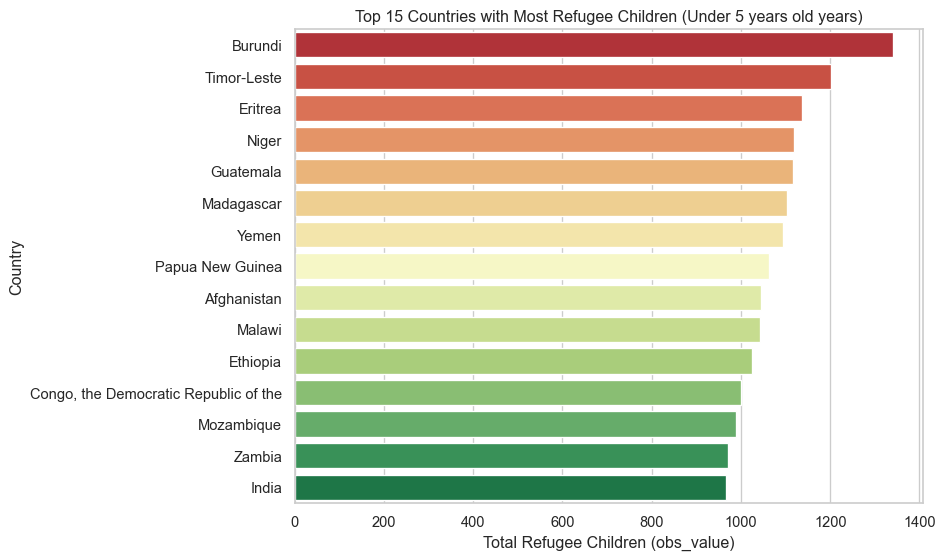


INSIGHT for Age Group: Under 5 years old
This bar plot visualizes the countries that have historically hosted the largest numbers of child refugees in this age group.
It highlights the disproportionate burden faced by a relatively small number of nations.
Policy makers could focus aid and support towards these nations. Note that this does not adjust for population size.


<Figure size 672x480 with 0 Axes>

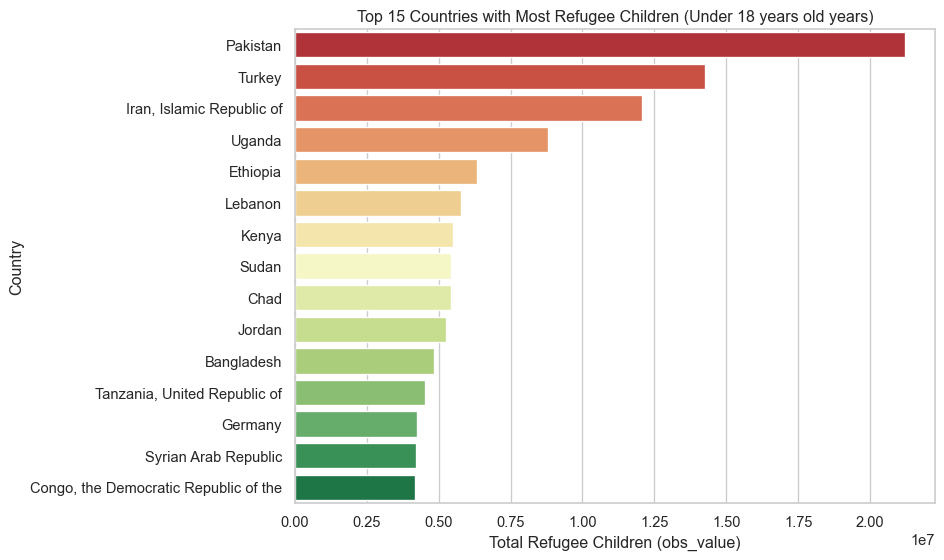


INSIGHT for Age Group: Under 18 years old
This bar plot visualizes the countries that have historically hosted the largest numbers of child refugees in this age group.
It highlights the disproportionate burden faced by a relatively small number of nations.
Policy makers could focus aid and support towards these nations. Note that this does not adjust for population size.


<Figure size 672x480 with 0 Axes>

In [15]:
if 'obs_value' in df.columns and 'country' in df.columns and 'current_age' in df.columns:
    try:
        # ✅ Loop only through non-null age groups
        for age_group in df['current_age'].dropna().unique():
            # Filter data for the current age group
            age_df = df[df['current_age'] == age_group]

            # Group and sort
            map_data = age_df.groupby("country")["obs_value"].sum().reset_index()
            top15_refugees = map_data.sort_values("obs_value", ascending=False).head(15)

            # Plotting
            plt.figure(figsize=(10, 6))
            sns.barplot(data=top15_refugees, x="obs_value", y="country", palette="RdYlGn")
            plt.title(f"Top 15 Countries with Most Refugee Children ({age_group} years)")
            plt.xlabel("Total Refugee Children (obs_value)")
            plt.ylabel("Country")
            plt.tight_layout()
            plt.show()
            plt.savefig(f"{save_dir}/top15_{age_group}.png")
            # Insight
            print(f"\nINSIGHT for Age Group: {age_group}")
            print("This bar plot visualizes the countries that have historically hosted the largest numbers of child refugees in this age group.")
            print("It highlights the disproportionate burden faced by a relatively small number of nations.")
            print("Policy makers could focus aid and support towards these nations. Note that this does not adjust for population size.\n")

    except Exception as e:
        print(f"Error creating top countries bar plot by current_age: {e}")
else:
    print("ERROR: Missing required columns ('obs_value', 'country', 'current_age') for age-grouped bar plot.")

# 10.3 INSIGHT #3: Global Refugee Children Over Time

Refugee Summary for Age Group Under 5 years old:
   time_period  obs_value
0   01-01-2000     4136.9
1   01-01-2001     4091.1
2   01-01-2002     4047.0
3   01-01-2003     3998.2
4   01-01-2004     3948.0
5   01-01-2005     3898.0
6   01-01-2006     3842.0
7   01-01-2007     3771.4
8   01-01-2008     3684.0
9   01-01-2009     3583.2
10  01-01-2010     3475.2
11  01-01-2011     3366.1
12  01-01-2012     3268.1
13  01-01-2013     3183.0
14  01-01-2014     3111.9
15  01-01-2015     3052.3
16  01-01-2016     2997.2
17  01-01-2017     2940.9
18  01-01-2018     2884.2
19  01-01-2019     2827.9
20  01-01-2020     2769.7
21  01-01-2021     2713.3
22  01-01-2022     2665.7

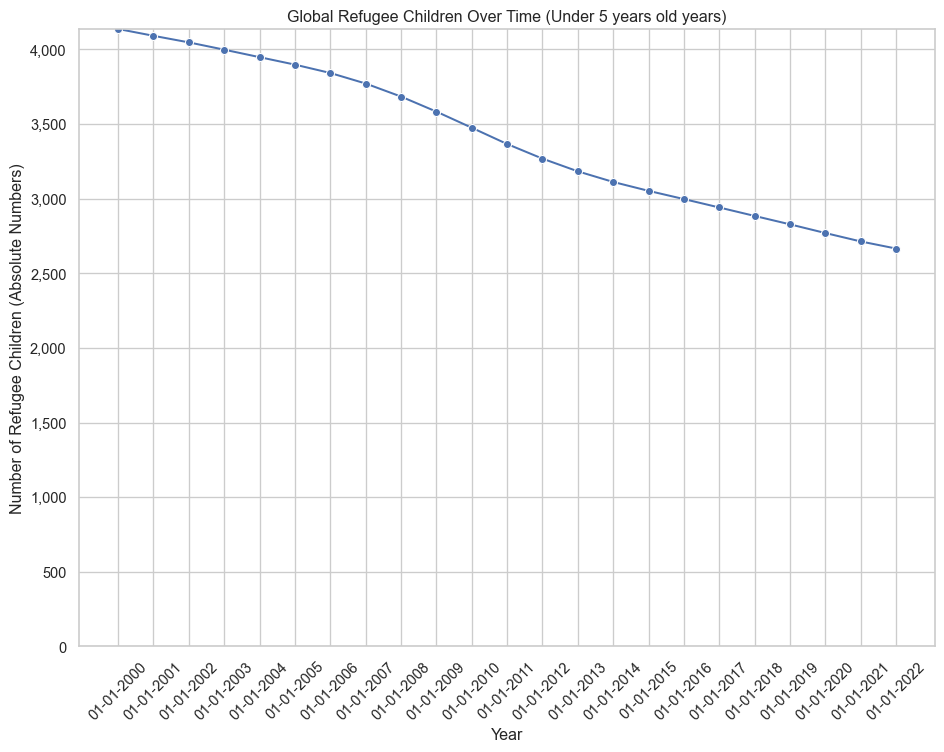


INSIGHT for Age Group: Under 5 years old
This line plot shows the trend of global refugee children numbers over the years for this specific age group.
It helps identify periods of spikes or declines, possibly linked to global crises, conflicts, or policy interventions.

Refugee Summary for Age Group Under 18 years old:
   time_period   obs_value
0   01-01-2001   4443958.0
1   01-01-2002   3218587.0
2   01-01-2003   3328651.0
3   01-01-2004   3474434.0
4   01-01-2005   2850816.0
5   01-01-2006   3092726.0
6   01-01-2007   6018812.0
7   01-01-2008   7236667.0
8   01-01-2009   7488414.0
9   01-01-2010   5625001.0
10  01-01-2011   3959406.0
11  01-01-2012   4179159.0
12  01-01-2013   4915337.0
13  01-01-2014   6312496.0
14  01-01-2015   6668064.0
15  01-01-2016   7125500.0
16  01-01-2017   8606131.0
17  01-01-2018   9292901.0
18  01-01-2019   8786583.0
19  01-01-2020   9097541.0
20  01-01-2021  10766482.0
21  01-01-2022  14162173.0
22  01-01-2023  15297214.0

<Figure size 672x480 with 0 Axes>

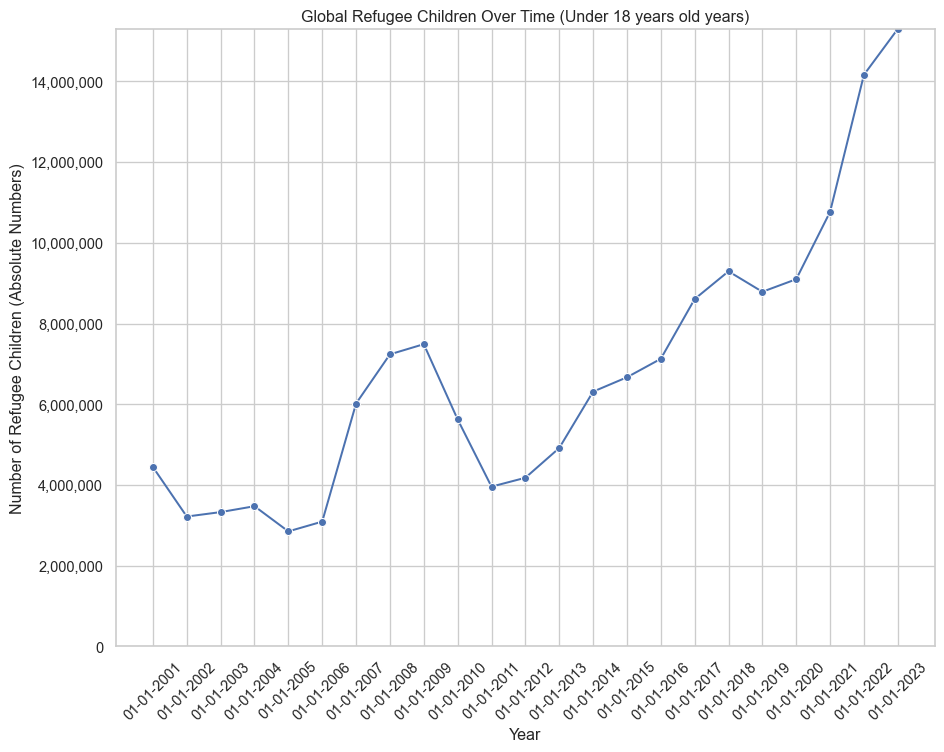


INSIGHT for Age Group: Under 18 years old
This line plot shows the trend of global refugee children numbers over the years for this specific age group.
It helps identify periods of spikes or declines, possibly linked to global crises, conflicts, or policy interventions.


<Figure size 672x480 with 0 Axes>

In [16]:
import matplotlib.ticker as ticker
# Assuming the data is already in the required format:
if 'obs_value' in df.columns and 'time_period' in df.columns and 'current_age' in df.columns:
    try:
        for age_group in df['current_age'].dropna().unique():
            age_df = df[df['current_age'] == age_group]

            # Group by time_period and get the sum of 'obs_value' (absolute number)
            refugee_summary = age_df.groupby("time_period")["obs_value"].sum().reset_index()

            # Debugging: Check the summary DataFrame
            print(f"Refugee Summary for Age Group {age_group}:")
            print(refugee_summary)

            # Plotting the data
            plt.figure(figsize=(10, 8))
            sns.lineplot(data=refugee_summary, x="time_period", y="obs_value", marker="o")
            plt.title(f"Global Refugee Children Over Time ({age_group} years)")
            plt.xlabel("Year")
            plt.ylabel("Number of Refugee Children (Absolute Numbers)")

            # Ensure Y-axis displays absolute numbers properly without scientific notation
            plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

            # Optional: Adjust the range of Y-axis if needed
            plt.ylim(0, max(refugee_summary["obs_value"].max(), 100))  # Automatically adjust Y-axis

            # Rotate x-axis labels and ensure integer ticks for x-axis
            plt.xticks(rotation=45)
            plt.locator_params(axis='x', integer=True)

            plt.tight_layout()
            # Explicitly show the plot
            plt.show()
            plt.savefig(f"{save_dir}/refugee_trend_{age_group}.png")

            # Insight
            print(f"\nINSIGHT for Age Group: {age_group}")
            print("This line plot shows the trend of global refugee children numbers over the years for this specific age group.")
            print("It helps identify periods of spikes or declines, possibly linked to global crises, conflicts, or policy interventions.\n")

    except Exception as e:
        print(f"Error creating refugee trend line plots by age group: {e}")
else:
    print("ERROR: Missing required columns ('obs_value', 'time_period', 'current_age') for trend line plots by age.")

# 10.4 INSIGHT #4: Average Stunting (Current Age)

Processing Age Group: Under 5 years old
Stunting Summary for Age Group Under 5 years old:
   time_period  obs_value
0   01-01-2000  26.018239
1   01-01-2001  25.730189
2   01-01-2002  25.452830
3   01-01-2003  25.145912
4   01-01-2004  24.830189
5   01-01-2005  24.515723
6   01-01-2006  24.163522
7   01-01-2007  23.719497
8   01-01-2008  23.169811
9   01-01-2009  22.535849
10  01-01-2010  21.856604
11  01-01-2011  21.170440
12  01-01-2012  20.554088
13  01-01-2013  20.018868
14  01-01-2014  19.571698
15  01-01-2015  19.196855
16  01-01-2016  18.850314
17  01-01-2017  18.496226
18  01-01-2018  18.139623
19  01-01-2019  17.785535
20  01-01-2020  17.419497
21  01-01-2021  17.064780
22  01-01-2022  16.765409

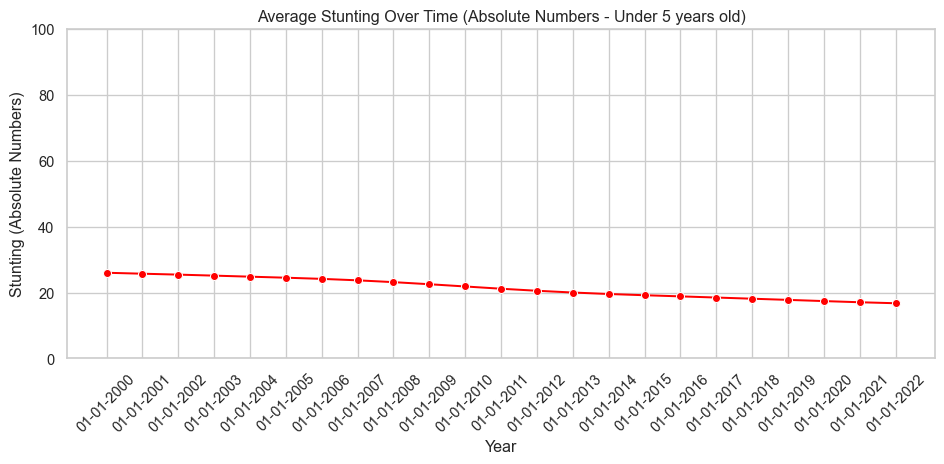


INSIGHT: Average Stunting Over Time for Age Group: Under 5 years old
This plot tracks stunting as absolute numbers over time for this specific age group.
It reveals both progress and persistent gaps in addressing undernutrition across years.

Processing Age Group: Under 18 years old
Stunting Summary for Age Group Under 18 years old:
   time_period     obs_value
0   01-01-2001  45346.510204
1   01-01-2002  32842.724490
2   01-01-2003  35411.180851
3   01-01-2004  34063.078431
4   01-01-2005  29089.959184
5   01-01-2006  30026.466019
6   01-01-2007  56781.245283
7   01-01-2008  62927.539130
8   01-01-2009  61380.442623
9   01-01-2010  49778.769912
10  01-01-2011  32454.147541
11  01-01-2012  33702.895161
12  01-01-2013  39639.814516
13  01-01-2014  50907.225806
14  01-01-2015  54211.902439
15  01-01-2016  58888.429752
16  01-01-2017  71717.758333
17  01-01-2018  86045.379630
18  01-01-2019  80610.853211
19  01-01-2020  79802.991228
20  01-01-2021  64086.202381
21  01-01-2022  86884.4969

<Figure size 672x480 with 0 Axes>

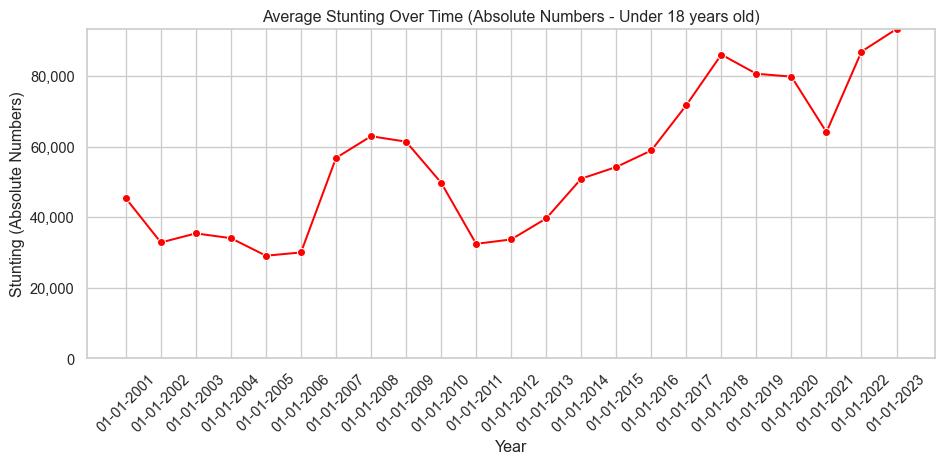


INSIGHT: Average Stunting Over Time for Age Group: Under 18 years old
This plot tracks stunting as absolute numbers over time for this specific age group.
It reveals both progress and persistent gaps in addressing undernutrition across years.


<Figure size 672x480 with 0 Axes>

In [17]:
# Assuming the data is already in the required format:
if 'obs_value' in df.columns and 'time_period' in df.columns and 'current_age' in df.columns:
    try:
        for age_group in df['current_age'].dropna().unique():
            age_df = df[df['current_age'] == age_group]
            
            # Debugging: Check if the DataFrame is empty
            print(f"Processing Age Group: {age_group}")
            if age_df.empty:
                print(f"Warning: No data for age group {age_group}. Skipping...")
                continue

            stunting_summary = age_df.groupby("time_period")["obs_value"].mean().reset_index()

            # Debugging: Check the summary DataFrame
            print(f"Stunting Summary for Age Group {age_group}:")
            print(stunting_summary)

            # ✅ Use absolute numbers (No multiplication for percentage)
            # stunting_summary["obs_value"] remains as is

            plt.figure(figsize=(10, 5))
            sns.lineplot(data=stunting_summary, x="time_period", y="obs_value", marker="o", color="red")
            plt.title(f"Average Stunting Over Time (Absolute Numbers - {age_group})")
            plt.xlabel("Year")
            plt.ylabel("Stunting (Absolute Numbers)")

            # Ensure Y-axis displays absolute numbers properly without scientific notation
            plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

            # Optional: Adjust the range of Y-axis if needed
            plt.ylim(0, max(stunting_summary["obs_value"].max(), 100))  # Automatically adjust Y-axis

            plt.xticks(rotation=45)
            plt.tight_layout()
            # Explicitly show the plot
            plt.show()
            plt.savefig(f"{save_dir}/stunting_{age_group}.png")

            # Insight
            print(f"\nINSIGHT: Average Stunting Over Time for Age Group: {age_group}")
            print("This plot tracks stunting as absolute numbers over time for this specific age group.")
            print("It reveals both progress and persistent gaps in addressing undernutrition across years.\n")

    except Exception as e:
        print(f"Error creating stunting trend line plot by age group: {e}")
else:
    print("ERROR: Missing required columns ('obs_value', 'time_period', 'current_age') for average stunting trend line plot.")

# 10.5 INSIGHT #5: Stunting Plot for 2022

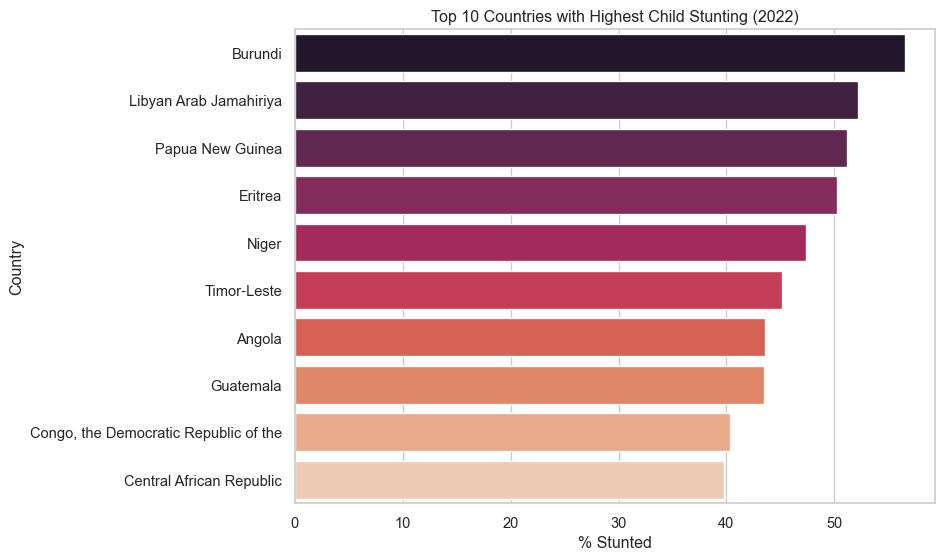

In [18]:
# Assuming 'indicator_2' is your DataFrame and it has 'time_period', 'obs_value', 'country' columns

# Define the timeline-style slider
year_slider = widgets.FloatSlider(
    value=max(indicator_2['time_period']),
    min=min(indicator_2['time_period']),
    max=max(indicator_2['time_period']),
    step=1,
    description='Year:',
    style={'description_width': 'initial'},
    continuous_update=False,  # ensures stable redraws
    readout=True,  # Show the year value on the slider
    orientation='horizontal',  # Horizontal slider for timeline effect
    layout=widgets.Layout(width='80%')  # Wider slider for timeline effect
)

# Output widget to show the plot
output = widgets.Output()

# Define the function to update the plot
def plot_stunting_by_country(change):
    with output:
        clear_output(wait=True)
        year = int(change['new'])  # Get the new year from the slider
        year_data = indicator_2[indicator_2['time_period'] == year]  # Filter the data for the selected year
        top10_stunting = year_data.sort_values("obs_value", ascending=False).head(10)  # Get the top 10 countries

        # Create the plot
        plt.figure(figsize=(10, 6))
        sns.barplot(data=top10_stunting, y="country", x="obs_value", palette="rocket")
        plt.title(f"Top 10 Countries with Highest Child Stunting ({year})")
        plt.xlabel("% Stunted")
        plt.ylabel("Country")
        plt.tight_layout()

        png_file = f"{save_dir}/stunting_plot_{year}.png"
        html_file = f"{save_dir}/stunting_plot_{year}.html" 

        # ✅ Save static image
        plt.savefig(png_file, dpi=300)

        # ✅ Save interactive HTML
        mpld3.save_html(plt.gcf(), html_file)

        # Embed the interactive HTML in notebook
        display(IFrame(src=html_file, width=1000, height=600))

# Bind the slider to the function
year_slider.observe(plot_stunting_by_country, names='value')

# Show the slider and output (you can uncomment these lines in your notebook)
# display(year_slider, output)

# Trigger initial plot for the first year
plot_stunting_by_country({'new': year_slider.value})

# 10.6 INSIGHT #6: Correlation Matrix and Heatmap

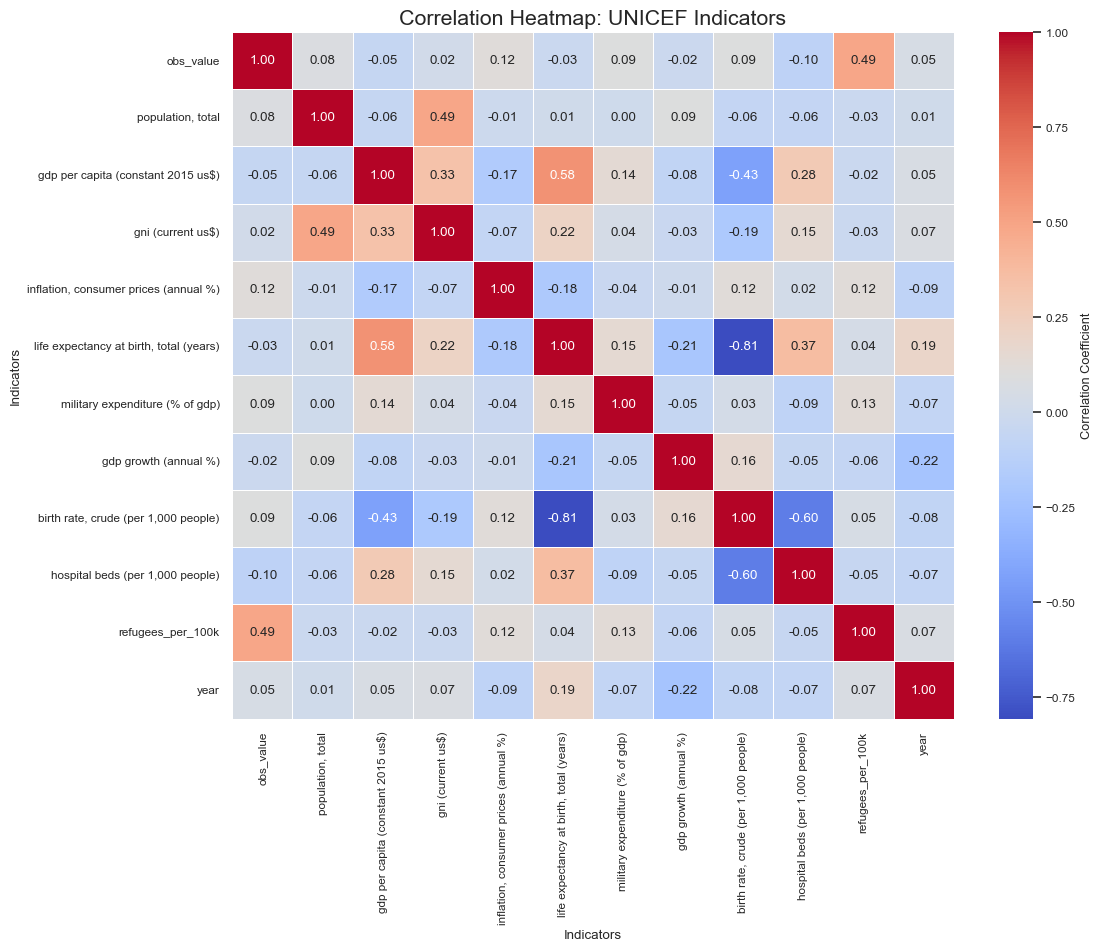


INSIGHT #5: Correlation Analysis
This correlation heatmap shows the relationships between the selected UNICEF indicators.
Correlation values range from -1 to 1:
  - Close to 1: Strong positive correlation
  - Close to -1: Strong negative correlation
  - Close to 0: Weak or no correlation
Use this heatmap to explore the relationships and potential dependencies between different indicators.

<Figure size 672x480 with 0 Axes>

In [19]:
try:
    # Corrected column names to match the DataFrame
    cols_for_corr = ['obs_value', 'population, total', 'gdp per capita (constant 2015 us$)', 'gni (current us$)',
                     'inflation, consumer prices (annual %)', 'life expectancy at birth, total (years)',
                     'military expenditure (% of gdp)', 'gdp growth (annual %)', 'birth rate, crude (per 1,000 people)',
                     'hospital beds (per 1,000 people)', 'refugees_per_100k', 'year']

    # Check if all columns exist in the DataFrame
    missing_cols = [col for col in cols_for_corr if col not in df.columns]
    if missing_cols:
        print(f"Warning: The following columns are missing in df: {missing_cols}")
    else:
        # Select only numeric columns that exist and are numeric
        numeric_df = df[cols_for_corr].apply(pd.to_numeric, errors='coerce').dropna()

        # Calculate the correlation matrix
        corr_matrix = numeric_df.corr()

        # Create the heatmap with improved style
        plt.figure(figsize=(12, 10))
        sns.set(font_scale=0.8)

        sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, linecolor='white',
                    cbar_kws={'label': 'Correlation Coefficient'}, annot_kws={'size': 10})

        # Title and labels
        plt.title("Correlation Heatmap: UNICEF Indicators", fontsize=16)
        plt.xlabel("Indicators", fontsize=10)
        plt.ylabel("Indicators", fontsize=10)

        plt.tight_layout()
        plt.show()
        plt.savefig(f"{save_dir}/correlation_matrix.png")

        # Insight
        print("\nINSIGHT #5: Correlation Analysis")
        print("This correlation heatmap shows the relationships between the selected UNICEF indicators.")
        print("Correlation values range from -1 to 1:")
        print("  - Close to 1: Strong positive correlation")
        print("  - Close to -1: Strong negative correlation")
        print("  - Close to 0: Weak or no correlation")
        print("Use this heatmap to explore the relationships and potential dependencies between different indicators.")

except Exception as e:
    print(f"Error creating correlation heatmap: {e}")

# 10.7 INSIGHT #7: Regression Analysis based on Correlation Heatmap

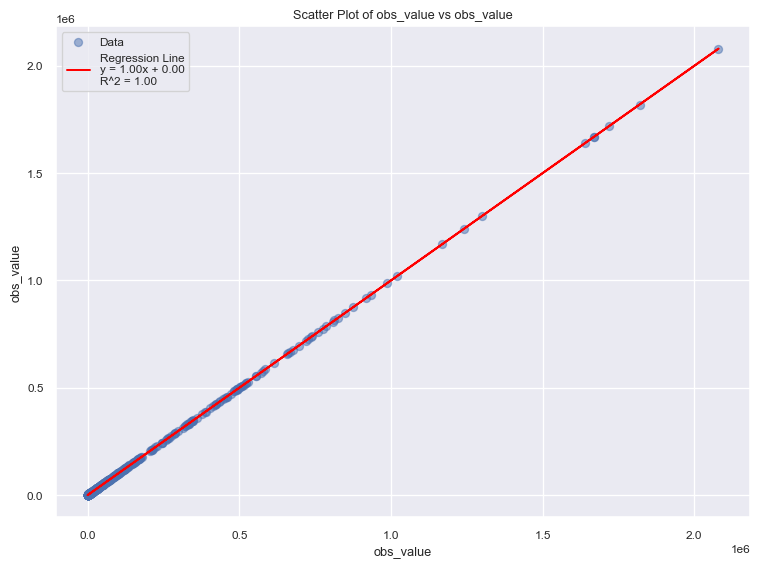

Generated scatter plot and regression line for obs_value vs obs_value

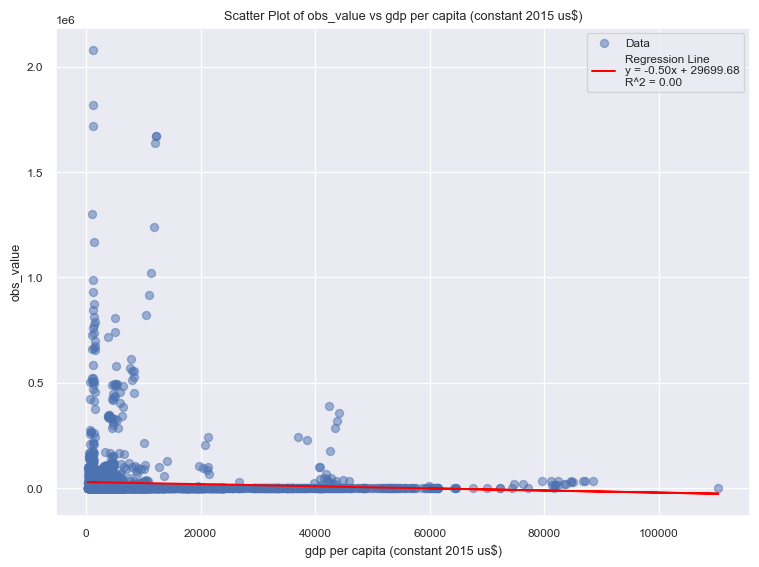

Generated scatter plot and regression line for obs_value vs gdp per capita (constant 2015 us$)

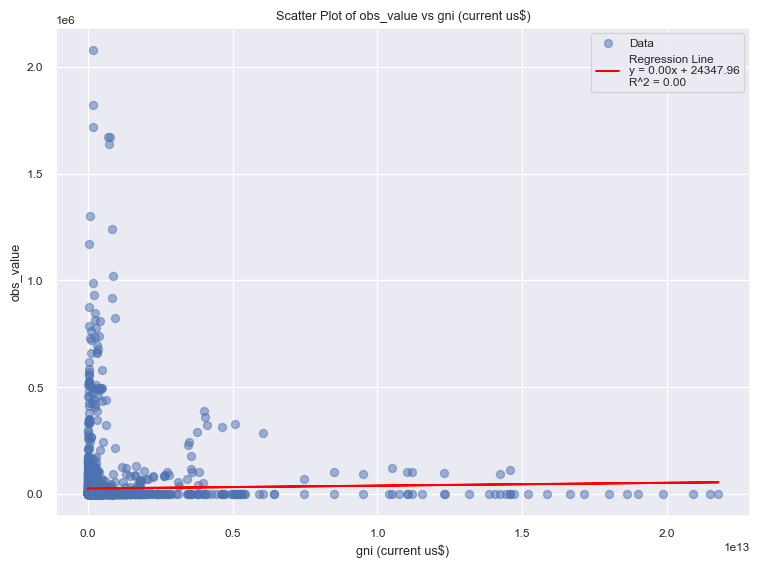

Generated scatter plot and regression line for obs_value vs gni (current us$)

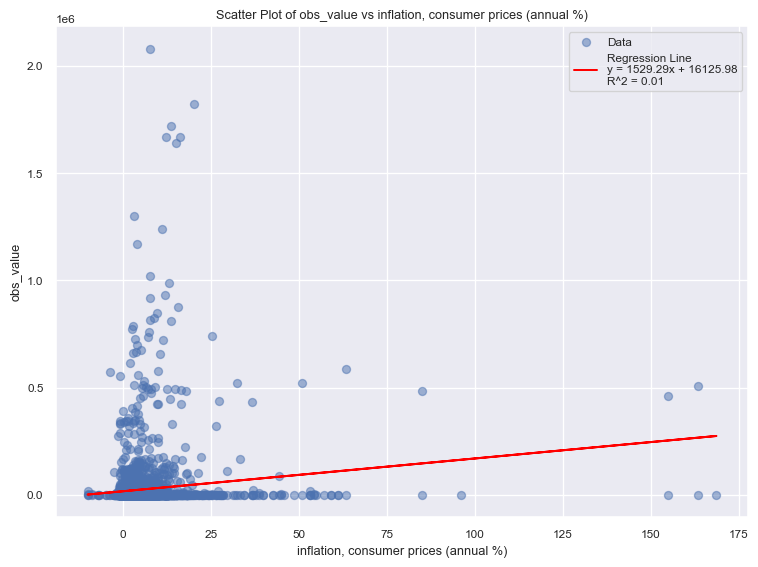

Generated scatter plot and regression line for obs_value vs inflation, consumer prices (annual %)

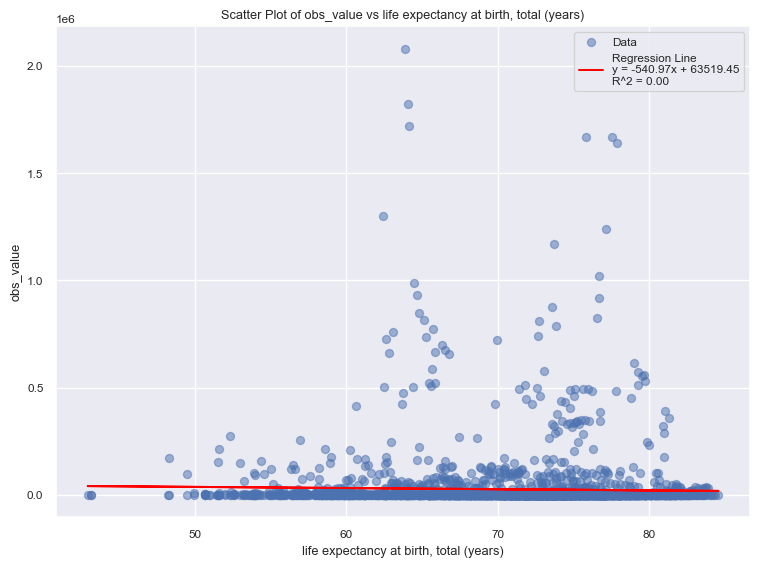

Generated scatter plot and regression line for obs_value vs life expectancy at birth, total (years)

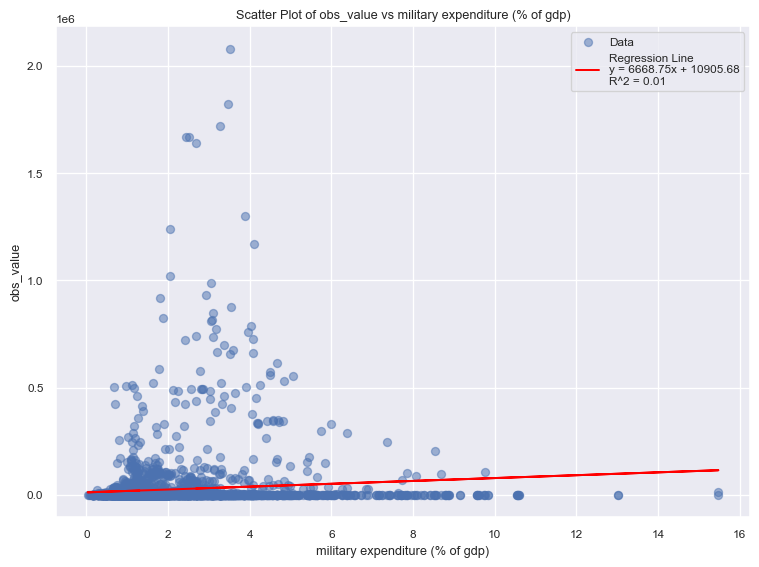

Generated scatter plot and regression line for obs_value vs military expenditure (% of gdp)

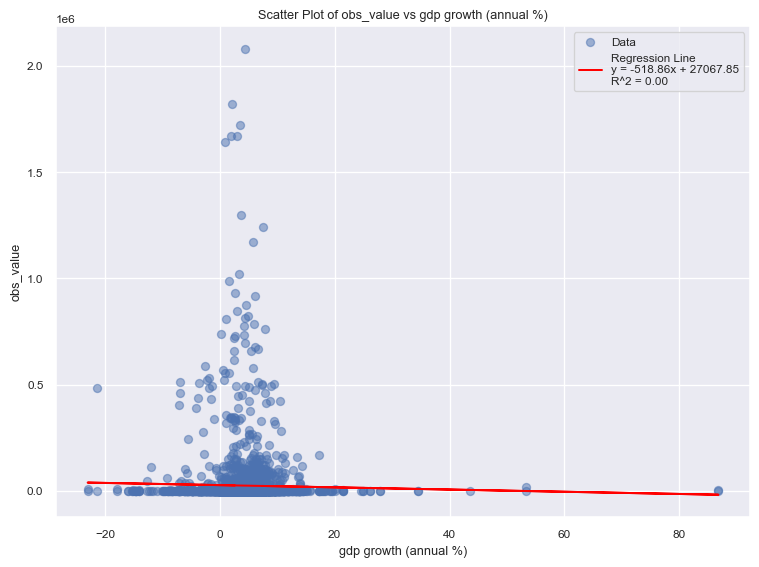

Generated scatter plot and regression line for obs_value vs gdp growth (annual %)

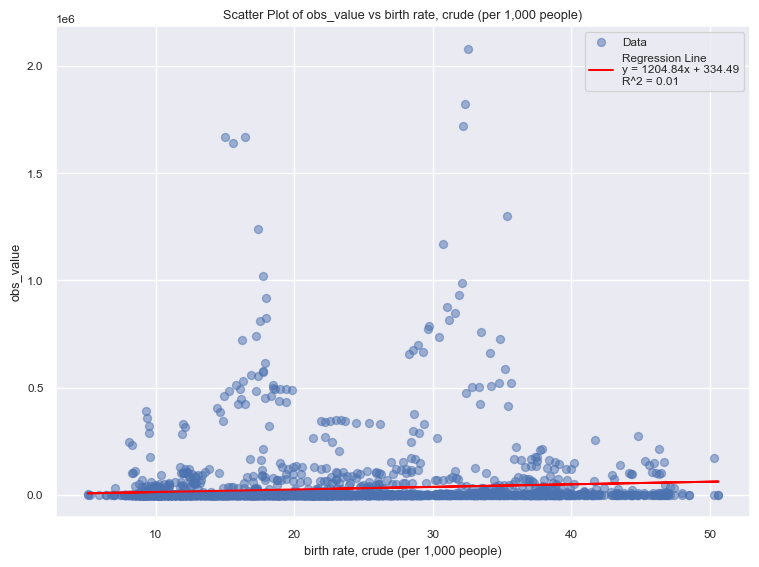

Generated scatter plot and regression line for obs_value vs birth rate, crude (per 1,000 people)

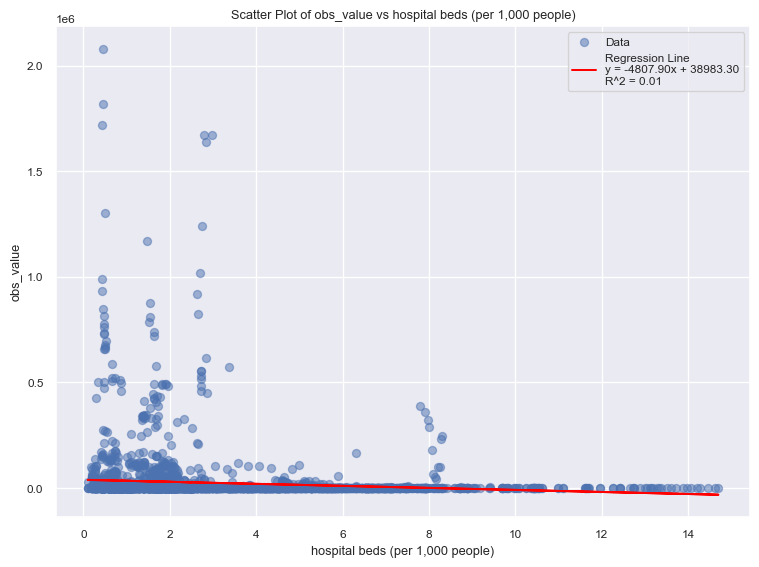

Generated scatter plot and regression line for obs_value vs hospital beds (per 1,000 people)

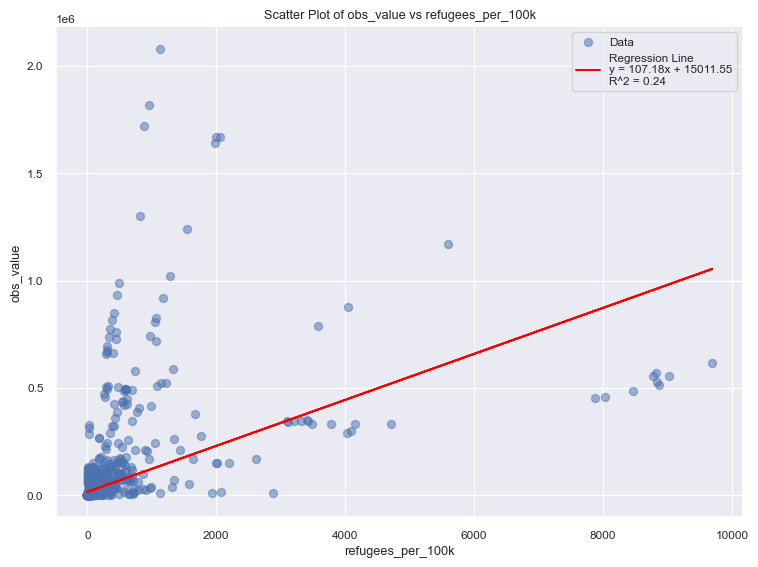

Generated scatter plot and regression line for obs_value vs refugees_per_100k
Operation Complete

In [20]:
# Define the columns for analysis
cols_for_analysis = [
    'obs_value', 'population', 'gdp per capita (constant 2015 us$)',
    'gni (current us$)', 'inflation, consumer prices (annual %)',
    'life expectancy at birth, total (years)', 'military expenditure (% of gdp)',
    'gdp growth (annual %)', 'birth rate, crude (per 1,000 people)',
    'hospital beds (per 1,000 people)','refugees_per_100k',
]

# Check if all the columns exist in the DataFrame
available_columns = [col for col in cols_for_analysis if col in df.columns]

# Apply numeric conversion to each column individually
for col in available_columns + ['obs_value']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values in any of the relevant columns
df = df.dropna(subset=available_columns + ['obs_value'])

# Function to plot regression
def plot_regression(x, y, col_name):
    try:
        # Perform linear regression
        model = np.polyfit(x, y, 1)
        slope, intercept = model

        # Calculate R-squared value
        correlation_matrix = np.corrcoef(x, y)
        correlation = correlation_matrix[0, 1]
        r_squared = correlation**2

        # Equation for the regression line
        equation = f'y = {slope:.2f}x + {intercept:.2f}'

        # Generate the plot
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, alpha=0.5, label='Data')
        plt.plot(x, slope * x + intercept, color='red', label=f'Regression Line\n{equation}\nR^2 = {r_squared:.2f}')
        plt.title(f'Scatter Plot of obs_value vs {col_name}')
        plt.xlabel(col_name)
        plt.ylabel('obs_value')
        plt.legend()  # Show legend
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f"{save_dir}/regression_{col_name}.png")
        plt.close()

        print(f"Generated scatter plot and regression line for obs_value vs {col_name}")
        
    except Exception as e:
        print(f"Error plotting {col_name}: {e}")

# Iterate over each independent variable and plot it against the dependent variable
for col in available_columns:
    # Extract the independent variable and dependent variable (obs_value)
    x = df[col]
    y = df['obs_value']

    # Handle cases where either x or y is empty
    if len(x) == 0 or len(y) == 0:
        print(f"Skipping plot for {col}: Insufficient data for linear regression.")
        continue

    # Plot the regression for the current variable
    plot_regression(x, y, col)

print("Operation Complete")

# Conclusion:

Refugee Situation: It appears that the number of refugees has a moderate
positive association to child stunting. It appears that the global
number of refugees has generally been increasing over time. The top 15
countries with the most refugees tend to be clustered around certain
countries. Economic Development and Health: GDP per capita and life
expectancy at birth exhibit a moderate positive correlation. This is
consistent with many of the historical values that have been observed
over time. Refugee Metrics: refugees_per_100k and refugee_burden_ratio
are strongly correlated. The refugees per 100k and refugee burden ratio
were constructed from the underlying data, and were made for use by
policy makers. It is expected that these values are highly correlated.
In conclusion, while individual factors may have complex relationships,
focusing on economic development alongside direct interventions for
refugee populations can contribute to both immediate relief and
sustained progress toward children.